<a href="https://colab.research.google.com/github/ArnavKetkar/Pytorch/blob/main/02_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Make classification data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(X[:5]), print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


(None, None)

In [5]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


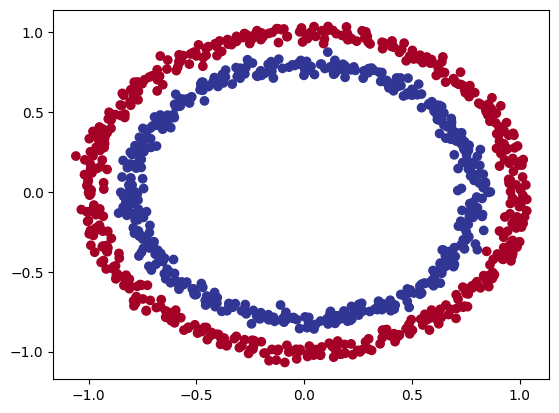

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

###Turning Data into Tensors and create test train splits

In [8]:
import torch
torch.__version__

'2.0.1+cu118'

In [9]:
type(X)

numpy.ndarray

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype

torch.float32

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_test)

(800, 200)

###Building a model

In [12]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2585,  0.7029],
                      [-0.4773, -0.1923],
                      [ 0.4880, -0.6061],
                      [ 0.2356,  0.1038],
                      [-0.5830,  0.1945]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4596, -0.5049, -0.1451, -0.0230, -0.6842], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2514,  0.2117, -0.2954,  0.0458,  0.1564]], device='cuda:0')),
             ('1.bias', tensor([0.1234], device='cuda:0'))])

In [16]:
untrained_preds = model0(X_test.to(device))
len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr = 0.1)

In [18]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train Model
1. Forward Pass
2. Calculate Loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer update

In [19]:
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]

y_logits


tensor([[-0.0199],
        [-0.1733],
        [ 0.1113],
        [-0.0559],
        [-0.3190]], device='cuda:0')

In [20]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4950],
        [0.4568],
        [0.5278],
        [0.4860],
        [0.4209]], device='cuda:0')

In [21]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]], device='cuda:0')

## Build training and testing loop

In [22]:
device

'cuda'

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model0.train()

  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> probs -> labels

  loss = loss_fn(y_logits, y_train) # becoz using BCE loss woth logits
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70517, Acc: 47.62% | Test Loss: 0.69934 | Test Acc: 49.50%
Epoch: 10 | Loss: 0.70006, Acc: 48.50% | Test Loss: 0.69570 | Test Acc: 49.00%
Epoch: 20 | Loss: 0.69799, Acc: 49.75% | Test Loss: 0.69444 | Test Acc: 49.00%
Epoch: 30 | Loss: 0.69696, Acc: 50.50% | Test Loss: 0.69392 | Test Acc: 49.50%
Epoch: 40 | Loss: 0.69632, Acc: 50.25% | Test Loss: 0.69363 | Test Acc: 50.00%
Epoch: 50 | Loss: 0.69585, Acc: 50.88% | Test Loss: 0.69342 | Test Acc: 50.50%
Epoch: 60 | Loss: 0.69549, Acc: 50.75% | Test Loss: 0.69327 | Test Acc: 51.00%
Epoch: 70 | Loss: 0.69518, Acc: 50.38% | Test Loss: 0.69315 | Test Acc: 51.00%
Epoch: 80 | Loss: 0.69492, Acc: 50.62% | Test Loss: 0.69306 | Test Acc: 51.00%
Epoch: 90 | Loss: 0.69470, Acc: 50.88% | Test Loss: 0.69299 | Test Acc: 51.00%


 ## Make Predictions

In [24]:
import requests
from pathlib import Path

# Download helper funcs
if Path('helper_functions.py').is_file():
  print("Already exists.")
else:
  print('Downloading helper functions')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

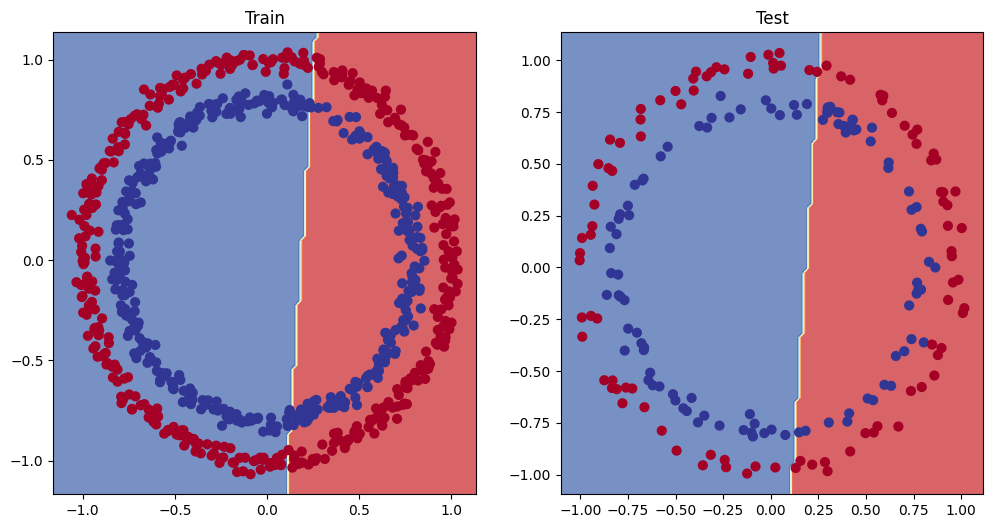

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model0, X_test, y_test)


In [26]:
# Building model with non linear activation function

from torch import nn

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.layer3(x)
    return x

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [27]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr = 0.1)

### Training model with non linearity

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model1.train()

  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> probs -> labels

  loss = loss_fn(y_logits, y_train) # becoz using BCE loss woth logits
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model1.eval()
  with torch.inference_mode():
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.69319 | Test Acc: 50.00%
Epoch: 10 | Loss: 0.69248, Acc: 50.50% | Test Loss: 0.69260 | Test Acc: 50.00%
Epoch: 20 | Loss: 0.69225, Acc: 59.13% | Test Loss: 0.69231 | Test Acc: 56.50%
Epoch: 30 | Loss: 0.69209, Acc: 70.25% | Test Loss: 0.69212 | Test Acc: 68.00%
Epoch: 40 | Loss: 0.69195, Acc: 68.38% | Test Loss: 0.69195 | Test Acc: 71.00%
Epoch: 50 | Loss: 0.69181, Acc: 58.25% | Test Loss: 0.69177 | Test Acc: 58.00%
Epoch: 60 | Loss: 0.69168, Acc: 54.00% | Test Loss: 0.69161 | Test Acc: 54.50%
Epoch: 70 | Loss: 0.69155, Acc: 53.12% | Test Loss: 0.69146 | Test Acc: 53.00%
Epoch: 80 | Loss: 0.69141, Acc: 52.62% | Test Loss: 0.69132 | Test Acc: 53.00%
Epoch: 90 | Loss: 0.69128, Acc: 52.75% | Test Loss: 0.69117 | Test Acc: 53.00%


In [29]:
model1.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model1(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

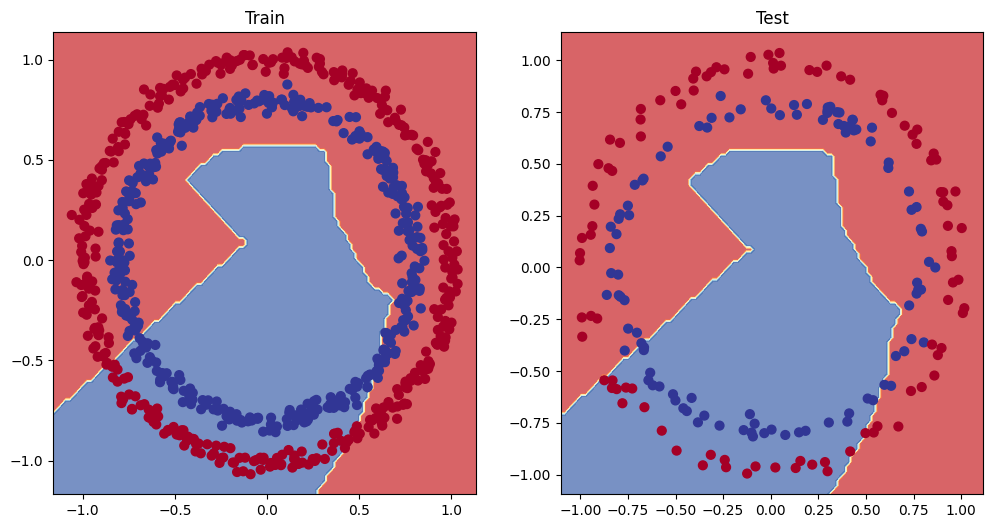

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model1, X_test, y_test)
